# Build a Traffic Sign Recognition Classifier Deep Learning

Some improvements are taken :
- [x] Adding of convolution networks at the same size of previous layer, to get 1x1 layer
- [x] Activation function use 'ReLU' instead of 'tanh'
- [x] Adaptative learning rate, so learning rate is decayed along to training phase
- [x] Enhanced training dataset

## Load and Visualize the Enhanced training dataset

From the original standard German Traffic Signs dataset, we add some 'generalized' sign to cover cases that the classifier can not well interpret small figures inside.  
`Also`, in our Enhanced training dataset, each figure is taken from standard library - not from road images, so they are very clear and in high-definition.

*Enhanced traffic signs &#8595;*  
<img src="figures/enhanced_training_dataset_text.png" alt="Drawing" style="width: 600px;"/>

Image Shape    : (32, 32, 3)

Enhanced Training Dataset   : 50 samples


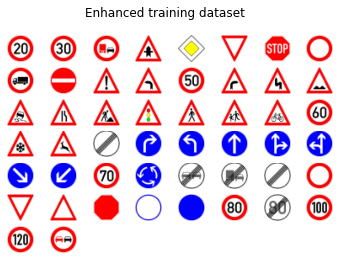

In [1]:
# load enhanced traffic signs
import os
import cv2
import matplotlib.pyplot as plot
import numpy
dir_enhancedsign     = 'figures\enhanced_training_dataset2'
files_enhancedsign   = [os.path.join(dir_enhancedsign, f) for f in os.listdir(dir_enhancedsign)]

# read & resize (32,32) images in enhanced dataset
images_enhancedsign  = numpy.array([cv2.cvtColor(cv2.resize(cv2.imread(f), (32,32), interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2RGB) for f in files_enhancedsign])

# plot new test images
fig, axes          = plot.subplots(7, 8)
plot.suptitle('Enhanced training dataset')
for i, ax in enumerate(axes.ravel()):
    if i < 50:
        ax.imshow(images_enhancedsign[i])
#         ax.set_title('{}'.format(i))
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
        ax.set_xticks([]), ax.set_yticks([])
    
    ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'enhancedsign' + '.jpg', dpi=700)

print("Image Shape    : {}".format(images_enhancedsign[0].shape))
print()
print("Enhanced Training Dataset   : {} samples".format(len(images_enhancedsign)))

In [2]:
# classes of enhanced dataset are taken from their filenames
import re
regex = re.compile(r'\d+')

y_enhancedsign = [int(regex.findall(f)[0]) for f in os.listdir(dir_enhancedsign)]
print(y_enhancedsign)

[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 6, 7, 8, 9]


*Enhanced German traffic signs dataset &#8595;*  
<img src="figures/enhanced_training_dataset.png" alt="Drawing" style="width: 600px;"/>

**We would have 50 classes in total with new enhanced training dataset :**

In [3]:
n_classes_enhanced = len(numpy.unique(y_enhancedsign))

print('n_classes enhanced      : {}'.format(n_classes_enhanced))

n_classes enhanced      : 50


## Load and Visualize the standard German Traffic Signs Dataset

In [4]:
# Load pickled data
import pickle
import numpy

# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file    = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train   = train['features'], train['labels'] # training dataset
X_valid, y_valid   = valid['features'], valid['labels'] # validation dataset used in training phase
X_test, y_test     = test['features'], test['labels']   # test dataset
n_classes_standard = len(numpy.unique(y_train))

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))
print("Image Shape    : {}".format(X_train[0].shape))
print()
print("Training Set   : {} samples".format(len(X_train)))
print("Validation Set : {} samples".format(len(X_valid)))
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes standard      : {}'.format(n_classes_standard))

Image Shape    : (32, 32, 3)

Training Set   : 34799 samples
Validation Set : 4410 samples
Test Set       : 12630 samples
n_classes standard      : 43


In [5]:
n_classes = n_classes_enhanced

## Implementation of LeNet

>http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf  
Above is the original article of Pierre Sermanet and Yann LeCun in 1998 that we can follow to create LeNet convolutional networks with a good accuracy even for very-beginners in deep-learning.  
It's really excited to see that many years of works now could be implemented in just 9 lines of code thank to Keras high-level API !
(low-level API implementation with Tensorflow 1 is roughly 20 lines of code)  

>Here is also an interesting medium article :  
https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086  

In [6]:
### Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


### 2-stage ConvNet architecture by Pierre Sermanet and Yann LeCun

We will try to implement the 2-stage ConvNet architecture by Pierre Sermanet and Yann LeCun which is not sequential. 

Keras disposes keras.Sequential() API for sequential architectures but it can not handle models with non-linear topology, shared layers or multi-in/output. So the choose of the 2-stage ConvNet architecture by `Pierre Sermanet` and `Yann LeCun` is to challenge us also.

<img src="figures/lenet_2.png" alt="Drawing" style="width: 550px;"/>

>Source: "Traffic Sign Recognition with Multi-Scale Convolutional Networks" by `Pierre Sermanet` and `Yann LeCun`

Here in this architecture, the 1st stage's ouput is feed-forward to the classifier (could be considered as a 3rd stage).

In [7]:
#LeNet model
inputs           = keras.Input(shape=(32,32,3), name='image_in')

#0 stage :conversion from normalized RGB [0..1] to HSV
layer_HSV        = tf.image.rgb_to_hsv(inputs)

#1st stage ___________________________________________________________
#Convolution with ReLU activation
layer1_conv      = keras.layers.Conv2D(256, kernel_size=(5,5), strides=1, activation='relu', padding='valid')(layer_HSV)
#Average Pooling
layer1_maxpool   = keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(layer1_conv)
#Conv 1x1
layer1_conv1x1   = keras.layers.Conv2D(256, kernel_size=(14,14), strides=1, activation='relu', padding='valid')(layer1_maxpool)

#2nd stage ___________________________________________________________
#Convolution with ReLU activation
layer2_conv      = keras.layers.Conv2D(64, kernel_size=(5,5), strides=1, activation='relu', padding='valid')(layer1_maxpool)
#MaxPooling 2D
layer2_maxpool   = keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(layer2_conv)
#Conv 1x1
layer2_conv1x1   = keras.layers.Conv2D(512, kernel_size=(5,5), strides=1, activation='relu', padding='valid')(layer2_maxpool)

#3rd stage | Classifier ______________________________________________
#Concate
layer3_flatten_1 = keras.layers.Flatten()(layer1_conv1x1)
layer3_flatten_2 = keras.layers.Flatten()(layer2_conv1x1)
layer3_concat    = keras.layers.Concatenate()([layer3_flatten_1, layer3_flatten_2])

#Dense (fully-connected)
layer3_dense_1     = keras.layers.Dense(units=129, activation='relu', kernel_initializer="he_normal")(layer3_concat)
# layer3_dense_2     = keras.layers.Dense(units=129, activation='relu', kernel_initializer="he_normal")(layer3_dense_1)
#Dense (fully-connected) | logits for 43 categories (n_classes)
outputs            = keras.layers.Dense(units=n_classes)(layer3_dense_1)

LeNet_Model        = keras.Model(inputs, outputs, name="LeNet_Model_improved")

Model: "LeNet_Model_improved"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_RGBToHSV (TensorFlo [(None, 32, 32, 3)]  0           image_in[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 256)  19456       tf_op_layer_RGBToHSV[0][0]       
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 256)  0           conv2d[0][0]                     
_______________________________________________________________________________

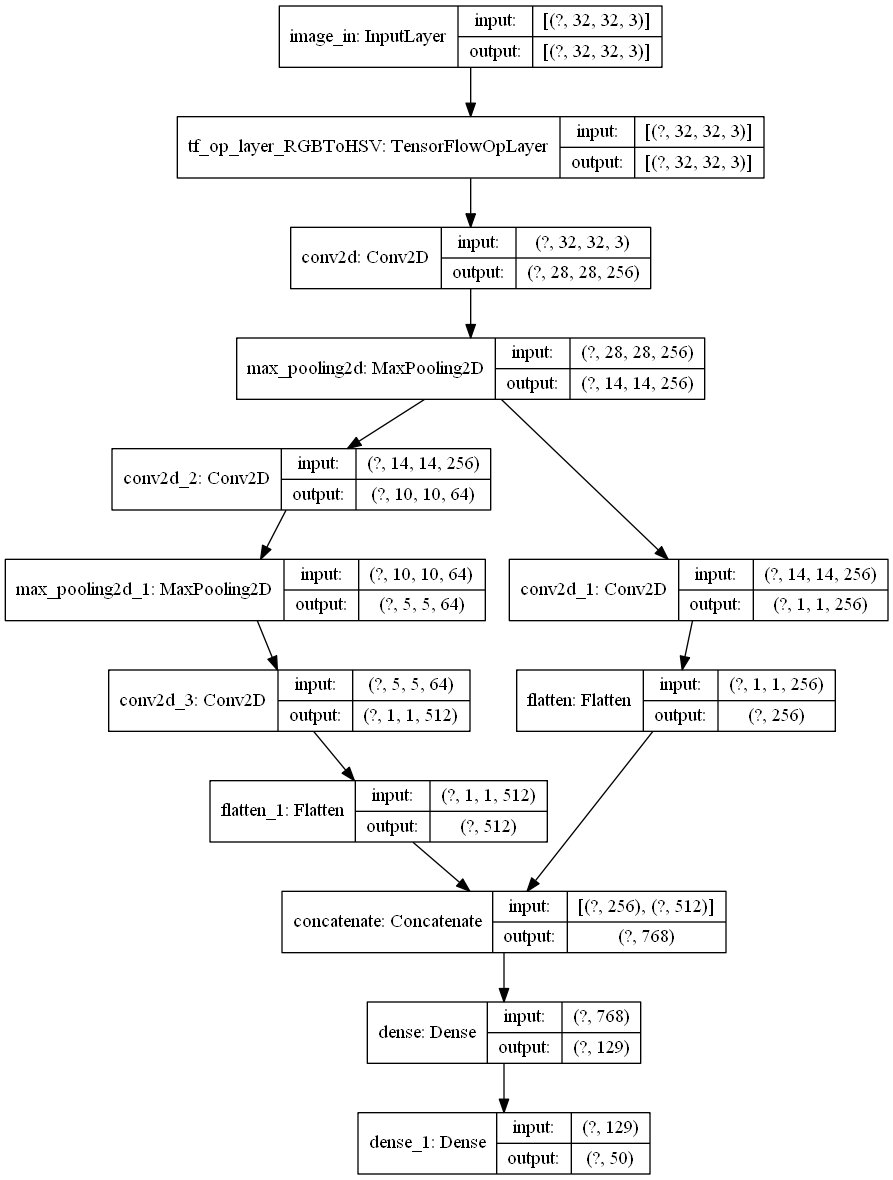

In [8]:
#Plot model architecture
LeNet_Model.summary()
keras.utils.plot_model(LeNet_Model, "figures/LeNet_improved_HLS.png", show_shapes=True)

### Input preprocessing

#### Color-Space
Pierre Sermanet and Yann LeCun used YUV color space with almost of processings on Y-channel (Y stands for brightness, U and V stand for Chrominance).  

#### Normalization
Each channel of an image is in uint8 scale (0-255), we will normalize each channel to 0-1.  
Generally, we normalize data to get them center around -1 and 1, to prevent numrical errors due to many steps of matrix operation. Imagine that we have 255x255x255x255xk operation, it could give a huge numerical error if we just have a small error in k.  

In [9]:
import cv2
def input_normalization(X_in):
    X       = numpy.float32(X_in/255.0)        
    return X

In [10]:
# normalization of dataset
# enhanced training dataset is added
X_train_norm         = input_normalization(X_train)
X_valid_norm         = input_normalization(X_valid)
X_enhancedtrain_norm = input_normalization(images_enhancedsign)

# one-hot matrix
y_train_onehot       = keras.utils.to_categorical(y_train, n_classes)
y_valid_onehot       = keras.utils.to_categorical(y_valid, n_classes)
y_enhanced_onehot    = keras.utils.to_categorical(y_enhancedsign, n_classes)

In [11]:
print(X_train_norm.shape)
print('{0:.4g}'.format(numpy.max(X_train_norm)))
print('{0:.3g}'.format(numpy.min(X_train_norm)))

(34799, 32, 32, 3)
1
0


In [12]:
print(X_enhancedtrain_norm.shape)
print('{0:.4g}'.format(numpy.max(X_enhancedtrain_norm)))
print('{0:.3g}'.format(numpy.min(X_enhancedtrain_norm)))

(50, 32, 32, 3)
1
0


### Training Pipeline
_Optimizer : we use Adam optimizer, better than SDG (Stochastic Gradient Descent)  
_Loss function : Cross Entropy by category  
_Metrics : accuracy  
*learning rate 0.001 work well with our network, it's better to try with small laerning rate in the begining.

In [13]:
rate = 0.001

LeNet_Model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate = rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

### Real-time data augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_enhanced = ImageDataGenerator(
                    rotation_range=30.0,
                    zoom_range=0.5,
                    width_shift_range=0.5,
                    height_shift_range=0.5,
                    featurewise_center=True,
                    featurewise_std_normalization=True,
                    horizontal_flip=False)

datagen_enhanced.fit(X_enhancedtrain_norm)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
            rotation_range=15.0,
            zoom_range=0.2,
            width_shift_range=0.1,
            height_shift_range=0.1,
            featurewise_center=False,
            featurewise_std_normalization=False,
            horizontal_flip=False)

datagen.fit(X_train_norm)

### Train the Model

###### on standard training dataset

In [16]:
EPOCHS          = 30
BATCH_SIZE      = 32
STEPS_PER_EPOCH = int(len(X_train_norm)/BATCH_SIZE)

history_standard_HLS = LeNet_Model.fit(
                datagen.flow(X_train_norm, y_train_onehot, batch_size=BATCH_SIZE,shuffle=True),
                validation_data=(X_valid_norm, y_valid_onehot),
                shuffle=True,
                steps_per_epoch=STEPS_PER_EPOCH,
                epochs=EPOCHS)

  ...
    to  
  ['...']
Train for 1087 steps, validate on 4410 samples
Epoch 1/30
1087/1087 [==============================] - 310s 285ms/step - loss: 1.5436 - accuracy: 0.5221 - val_loss: 1.1918 - val_accuracy: 0.6120
Epoch 2/30
1087/1087 [==============================] - 305s 281ms/step - loss: 0.5978 - accuracy: 0.7973 - val_loss: 0.8420 - val_accuracy: 0.7415
Epoch 3/30
1087/1087 [==============================] - 304s 279ms/step - loss: 0.3351 - accuracy: 0.8877 - val_loss: 0.8672 - val_accuracy: 0.7873
Epoch 4/30
1087/1087 [==============================] - 304s 279ms/step - loss: 0.2341 - accuracy: 0.9236 - val_loss: 0.7044 - val_accuracy: 0.8091
Epoch 5/30
1087/1087 [==============================] - 304s 279ms/step - loss: 0.1861 - accuracy: 0.9395 - val_loss: 0.6862 - val_accuracy: 0.8245
Epoch 6/30
1087/1087 [==============================] - 304s 279ms/step - loss: 0.1643 - accuracy: 0.9459 - val_loss: 0.6359 - val_accuracy: 0.8508
Epoch 7/30
1087/1087 [==================

###### on enhanced training dataset

In [17]:
EPOCHS          = 30
BATCH_SIZE      = 1
STEPS_PER_EPOCH = int(len(X_enhancedtrain_norm)/BATCH_SIZE)

history_enhanced_HLS         = LeNet_Model.fit(
                datagen_enhanced.flow(X_enhancedtrain_norm, y_enhanced_onehot, batch_size=BATCH_SIZE,shuffle=True),                
                shuffle=True, #validation_data=(X_valid_norm, y_valid_onehot),
                steps_per_epoch=STEPS_PER_EPOCH,
                epochs=EPOCHS)

  ...
    to  
  ['...']
Train for 50 steps
Epoch 1/30
50/50 [==============================] - 11s 229ms/step - loss: 351.2083 - accuracy: 0.0400
Epoch 2/30
50/50 [==============================] - 11s 219ms/step - loss: 142.5382 - accuracy: 0.0000e+00
Epoch 3/30
50/50 [==============================] - 11s 218ms/step - loss: 44.1551 - accuracy: 0.0400
Epoch 4/30
50/50 [==============================] - 11s 217ms/step - loss: 14.9848 - accuracy: 0.0200
Epoch 5/30
50/50 [==============================] - 11s 217ms/step - loss: 131.3266 - accuracy: 0.0000e+00
Epoch 6/30
50/50 [==============================] - 11s 217ms/step - loss: 540.1987 - accuracy: 0.0200
Epoch 7/30
50/50 [==============================] - 11s 217ms/step - loss: 5.0112 - accuracy: 0.0000e+00
Epoch 8/30
50/50 [==============================] - 11s 217ms/step - loss: 16.5539 - accuracy: 0.0200
Epoch 9/30
50/50 [==============================] - 11s 217ms/step - loss: 25.3070 - accuracy: 0.0200
Epoch 10/30
50/50 [====

In [18]:
LeNet_Model.save("LeNet_enhanced_trainingdataset_HLS.h5")

### Evaluate the Model
We will use the test dataset to evaluate classification accuracy.

In [19]:
#Normalize test dataset
X_test_norm   = input_normalization(X_test)
#One-hot matrix
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)

In [20]:
#Load saved model
reconstructed_LeNet_Model = keras.models.load_model("LeNet_enhanced_trainingdataset_HLS.h5")

#Evaluate and display the prediction
result                    = reconstructed_LeNet_Model.evaluate(X_test_norm,y_test_onehot)
dict(zip(reconstructed_LeNet_Model.metrics_names, result))

12630/12630 [==============================] - 26s 2ms/sample - loss: 3.9001 - accuracy: 0.0119s - loss: 3.9003 - accuracy: 


{'loss': 3.900066901989995, 'accuracy': 0.011876484}

In [21]:
pickle.dump(history_enhanced_HLS.history, open( "history_LeNet_enhanced_trainingdataset_enhanced_HLS.p", "wb" ))
pickle.dump(history_standard_HLS.history, open( "history_LeNet_enhanced_trainingdataset_standard_HLS.p", "wb" ))

In [22]:
with open("history_LeNet_enhanced_trainingdataset_standard_HLS.p", mode='rb') as f:
    history_ = pickle.load(f)


Plot of training error over 30 epochs:


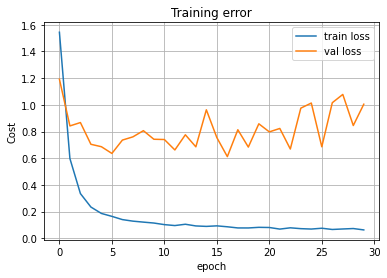

In [23]:
import matplotlib.pyplot as plt

# Plot training error.
print('\nPlot of training error over 30 epochs:')
fig = plt.figure()
plt.title('Training error')
plt.ylabel('Cost')
plt.xlabel('epoch')
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.grid()
plt.show()
fig.savefig('figures/Training_loss_LeNet_enhanced_trainingdataset_standard_HLS.png', dpi=500)


Plot of training accuracy over 30 epochs:


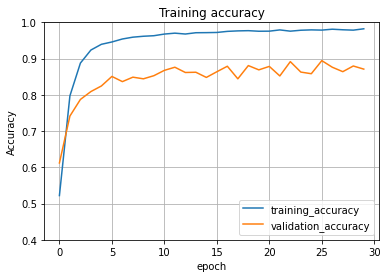

In [24]:
# Plot training error.
print('\nPlot of training accuracy over 30 epochs:')
fig = plt.figure()
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.xlabel('epoch')
plt.plot(history_['accuracy'])
plt.plot(history_['val_accuracy'])
plt.legend(['training_accuracy', 'validation_accuracy'], loc='lower right')
plt.grid()
plt.show()
fig.savefig('figures/Training_accuracy_LeNet_enhanced_trainingdataset_HLS.png', dpi=500)

### Prediction of test dataset with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.

In [25]:
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
X_test.shape

Test Set       : 12630 samples
n_classes      : 50


(12630, 32, 32, 3)

In [26]:
#Normalize test dataset
X_test_norm   = input_normalization(X_test)
#One-hot matrix
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)

In [27]:
#Load saved model
reconstructed = keras.models.load_model("LeNet_enhanced_trainingdataset_HLS.h5")

#Evaluate and display the prediction
prediction_performance    = reconstructed.evaluate(X_test_norm,y_test_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

12630/12630 [==============================] - 32s 3ms/sample - loss: 3.9001 - accuracy: 0.0119


{'loss': 3.900066901989995, 'accuracy': 0.011876484}

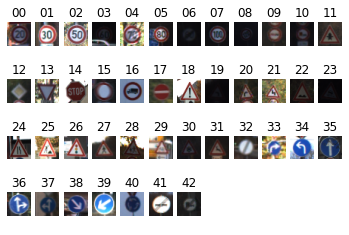

In [28]:
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 4, 12
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes_standard :
        X_test_of_class = X_test[y_test == idx]
        #X_train_0       = X_train_of_class[numpy.random.randint(len(X_train_of_class))]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        ax.axis('off')
        ax.set_title('{:02d}'.format(idx))
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.axis('off')
#
plot.draw()
fig.savefig('figures/' + 'test_representative' + '.jpg', dpi=700)

In [29]:
#### Prediction for all instances inside the test dataset
y_pred_proba   = reconstructed.predict(X_test_norm)
y_pred_class   = y_pred_proba.argmax(axis=-1)

### Showing prediction results for 10 first instances
for i, pred in enumerate(y_pred_class):
    if i <= 10:        
        print('Image {} - Target = {}, Predicted = {}'.format(i, y_test[i], pred))
    else:
        break

Image 0 - Target = 16, Predicted = 6
Image 1 - Target = 1, Predicted = 6
Image 2 - Target = 38, Predicted = 6
Image 3 - Target = 33, Predicted = 6
Image 4 - Target = 11, Predicted = 6
Image 5 - Target = 38, Predicted = 6
Image 6 - Target = 18, Predicted = 6
Image 7 - Target = 12, Predicted = 6
Image 8 - Target = 25, Predicted = 6
Image 9 - Target = 35, Predicted = 6
Image 10 - Target = 12, Predicted = 6


We will display a confusion matrix on test dataset to figure out our error-rate.  
`X_test_norm`    : test dataset  
`y_test`         : test dataset ground truth labels  
`y_pred_class`   : prediction labels on test dataset  

In [30]:
confusion_matrix = numpy.zeros([n_classes, n_classes])

#### confusion_matrix
`column`      : test dataset ground truth labels  
`row`         : prediction labels on test dataset  
`diagonal`    : incremented when prediction matches ground truth label  

In [31]:
for ij in range(len(X_test_norm)):
    if y_test[ij] == y_pred_class[ij]:
        confusion_matrix[y_test[ij],y_test[ij]] += 1
    else:
        confusion_matrix[y_pred_class[ij],y_test[ij]] -= 1

In [32]:
column_label = ['     L % d' % x for x in range(n_classes)]
row_label    = ['     P % d' % x for x in range(n_classes)]

In [33]:
# Plot classe representatives
import matplotlib.pyplot as plot
%matplotlib inline
rows, cols   = 1, 43
fig, axes    = plot.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        X_test_of_class = X_test[y_test == idx]
        X_test_0        = X_test_of_class[0]
        ax.imshow(X_test_0)
        plot.setp(ax.get_xticklabels(), visible=False)
        plot.setp(ax.get_yticklabels(), visible=False)
        # plot.tick_params(axis='both', which='both', bottom='off', top='off',
        # labelbottom='off', right='off', left='off', labelleft='off')
        ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'label_groundtruth' + '.jpg', dpi=3500)

In [34]:
numpy.savetxt("confusion_matrix_LeNet_enhanced_trainingdataset_HLS.csv", confusion_matrix, delimiter=";")

#### Thank to confusion matrix, we could identify where to enhance  
-[x] training dataset  
-[x] real-time data augmentation  
-[x] preprocessing  

*Extract of confusion matrix of classification on test dataset &#8595;*  
<img src="figures/confusion_matrix_LeNet_enhanced_trainingdataset_HLS.png" alt="Drawing" style="width: 750px;"/>

### Prediction of new instances with trained model
We will use the test dataset to test trained model's prediction of instances that it has never seen during training.
I didn't 'softmax' activation in the last layer of LeNet architecture, so the output prediction is logits. To have prediction confidence level, we can apply softmax function to output logits.

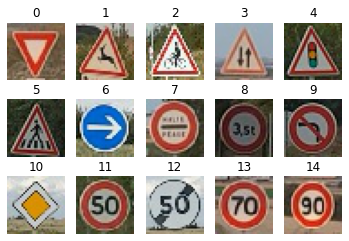

In [35]:
# load french traffic signs
import os
import cv2
import matplotlib.pyplot as plot
import numpy
dir_frenchsign     = 'french_traffic-signs-data'
images_frenchsign  = [os.path.join(dir_frenchsign, f) for f in os.listdir(dir_frenchsign)]
images_frenchsign  = numpy.array([cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in images_frenchsign])

# plot new test images
fig, axes          = plot.subplots(3, int(len(images_frenchsign)/3))
plot.title('French traffic signs')
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images_frenchsign[i])
    ax.set_title('{}'.format(i))
    plot.setp(ax.get_xticklabels(), visible=False)
    plot.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis('off')
plot.draw()
fig.savefig('figures/' + 'french_sign' + '.jpg', dpi=700)

*Enhanced German traffic signs dataset &#8595;*  
<img src="figures/enhanced_training_dataset.png" alt="Drawing" style="width: 700px;"/>

In [36]:
# manually label for these new images
y_frenchsign       = [13, 31, 29, 24, 26, 27, 33, 17, 15, 34, 12, 2, 2, 4, 2]
n_classes          = n_classes_enhanced

# when a sign doesn't present in our training dataset, we'll try to find a enough 'similar' sign to label it.

# image 2 : class 29 differed 
# image 3 : class 24, double-sens not existed 
# image 5 : class 27 differed
# image 6 : class 33 not existed 
# image 7 : class 17, halte-péage not existed 
# image 8 : class 15, 3.5t limit not existed 
# image 9 : class 15, turn-left inhibition not existed
# image 12 : class 2, ending of 50kmh speed-limit not existed
# image 14 : class 2, 90kmh speed-limit not existed

#### it's really intersting that somes common french traffic signs are not present in INI German traffic signs dataset or differed
Whatever our input - evenif it's not present in the training dataset, by using softmax activation our classififer can not say that 'this is a new traffic sign that it doesn't recognize' (sum of probability across all classes is 1), it's just try to find class that probably suit for the input.

In [37]:
#Normalize the dataset
X_frenchsign_norm        = input_normalization(images_frenchsign)
#One-hot matrix
y_frenchsign_onehot      = keras.utils.to_categorical(y_frenchsign, n_classes)

#Load saved model
reconstructed            = keras.models.load_model("LeNet_enhanced_trainingdataset_HLS.h5")

#Evaluate and display the prediction performance
prediction_performance   = reconstructed.evaluate(X_frenchsign_norm, y_frenchsign_onehot)
dict(zip(reconstructed.metrics_names, prediction_performance))

15/15 [==============================] - 0s 24ms/sample - loss: 3.9201 - accuracy: 0.0000e+00


{'loss': 3.920123338699341, 'accuracy': 0.0}

In [38]:
#### Prediction for all instances inside the test dataset
y_pred_logits            = reconstructed.predict(X_frenchsign_norm)
y_pred_proba             = tf.nn.softmax(y_pred_logits).numpy()
y_pred_class             = y_pred_proba.argmax(axis=-1)

### Showing prediction results
for i, pred in enumerate(y_pred_class):   
    print('Image {} - Target = {}, Predicted = {}'.format(i, y_frenchsign[i], pred))

Image 0 - Target = 13, Predicted = 6
Image 1 - Target = 31, Predicted = 6
Image 2 - Target = 29, Predicted = 6
Image 3 - Target = 24, Predicted = 6
Image 4 - Target = 26, Predicted = 6
Image 5 - Target = 27, Predicted = 6
Image 6 - Target = 33, Predicted = 6
Image 7 - Target = 17, Predicted = 6
Image 8 - Target = 15, Predicted = 6
Image 9 - Target = 34, Predicted = 6
Image 10 - Target = 12, Predicted = 6
Image 11 - Target = 2, Predicted = 6
Image 12 - Target = 2, Predicted = 6
Image 13 - Target = 4, Predicted = 6
Image 14 - Target = 2, Predicted = 6


*French traffic signs to classsify &#8595;*  
<img src="figures/french_sign_compare_german_INI_enhanced.jpg" alt="Drawing" style="width: 750px;"/>

Top 3 model predictions for image 0 (Target is 13)
   Prediction = 02 with probability 0.0250 (logit is 0.1806)
   Prediction = 31 with probability 0.0262 (logit is 0.2275)
   Prediction = 06 with probability 0.0292 (logit is 0.3377)
Top 3 model predictions for image 1 (Target is 31)
   Prediction = 02 with probability 0.0250 (logit is 0.1806)
   Prediction = 31 with probability 0.0262 (logit is 0.2275)
   Prediction = 06 with probability 0.0292 (logit is 0.3377)
Top 3 model predictions for image 2 (Target is 29)
   Prediction = 02 with probability 0.0250 (logit is 0.1806)
   Prediction = 31 with probability 0.0262 (logit is 0.2275)
   Prediction = 06 with probability 0.0292 (logit is 0.3377)
Top 3 model predictions for image 3 (Target is 24)
   Prediction = 02 with probability 0.0250 (logit is 0.1806)
   Prediction = 31 with probability 0.0262 (logit is 0.2275)
   Prediction = 06 with probability 0.0292 (logit is 0.3377)
Top 3 model predictions for image 4 (Target is 26)
   Prediction

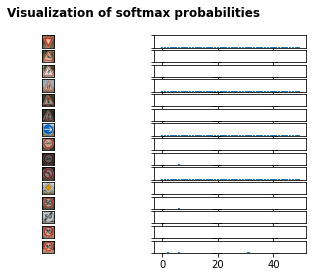

In [39]:
#### plot softmax probs along with traffic sign examples
n_img        = X_frenchsign_norm.shape[0]
fig, axarray = plot.subplots(n_img, 2)
plot.suptitle('Visualization of softmax probabilities', fontweight='bold')
for r in range(0, n_img):
    axarray[r, 0].imshow(numpy.squeeze(images_frenchsign[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plot.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plot.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(numpy.arange(n_classes), y_pred_proba[r])
    axarray[r, 1].set_ylim([0, 1])
    plot.setp(axarray[r, 1].get_yticklabels(), visible=False)
plot.draw()
fig.savefig('figures/' + 'french_sign_softmax_visuali_LeNet_enhanced_trainingdataset_HLS' + '.jpg', dpi=700)
    
K = 3
#### print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(images_frenchsign)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, y_frenchsign[i]))
    top_3_idx    = numpy.argsort(y_pred_proba[i])[-3:]
    top_3_values = y_pred_proba[i][top_3_idx]    
    top_3_logits = y_pred_logits[i][top_3_idx]    
    for k in range(K):
        print('   Prediction = {:02d} with probability {:.4f} (logit is {:.4f})'.format(top_3_idx[k], top_3_values[k], top_3_logits[k]))

*Visualization of softmax probabilities &#8595;*  
<img src="figures/french_sign_softmax_visuali_LeNet_enhanced_trainingdataset_HLS.jpg" alt="Drawing" style="width: 750px;"/>

## Visualization of layers

In [40]:
### Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
import matplotlib.pyplot as plot

print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


In [41]:
# Load pickled data
import pickle
import numpy

training_file    = 'traffic-signs-data/train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
n_classes        = len(numpy.unique(y_train))

In [42]:
import cv2
def input_normalization(X_in):
    X       = numpy.float32(X_in/255.0)        
    return X

# normalization of dataset
X_train_norm     = input_normalization(X_train)

# one-hot matrix
y_train_onehot   = keras.utils.to_categorical(y_train, n_classes)

In [43]:
#Load saved model
reconstructed            = keras.models.load_model("LeNet_enhanced_trainingdataset_HLS.h5")

#Build model for layer display
layers_output            = [layer.output for layer in reconstructed.layers]
outputs_model            = Model(inputs=reconstructed.input, outputs=layers_output)
outputs_history          = outputs_model.predict(X_train_norm[900].reshape(1,32,32,3))

#### Display analized input

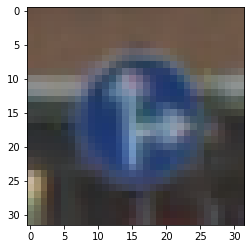

In [44]:
plot.imshow(X_train[900])

In [45]:
def display_layer(outputs_history, col_size, row_size, layer_index): 
    activation       = outputs_history[layer_index]
    activation_index = 0
    fig, ax          = plot.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].axis('off')
            if activation_index < activation.shape[3]:
                ax[row][col].imshow(activation[0, :, :, activation_index])   # , cmap='gray'             
                activation_index += 1

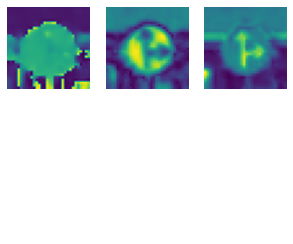

In [46]:
display_layer(outputs_history, 3, 2, 1)

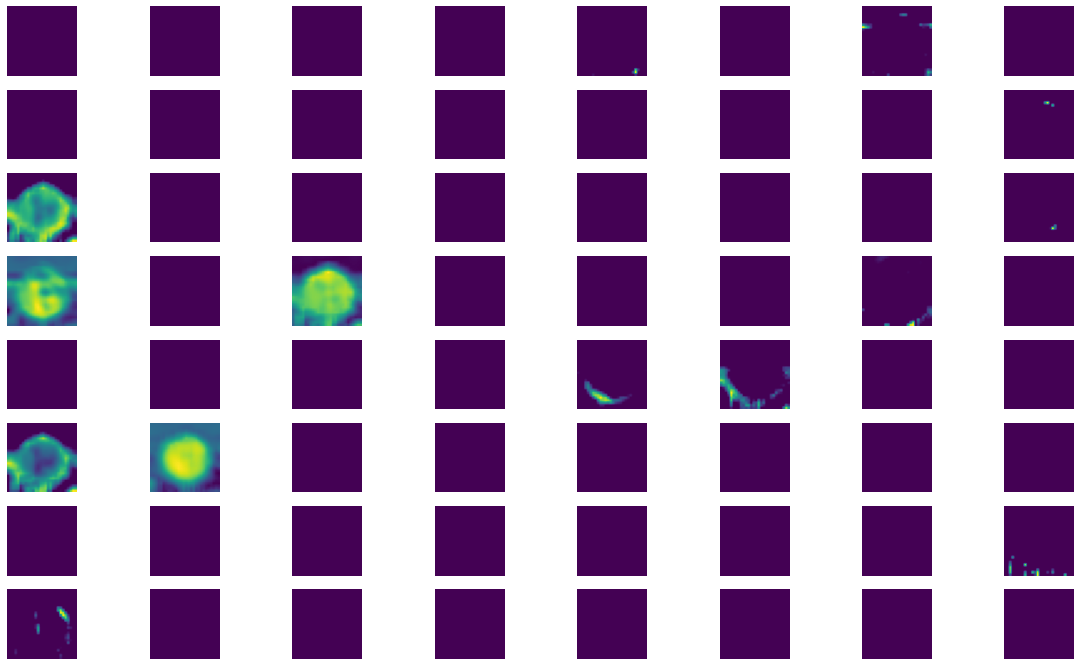

In [47]:
display_layer(outputs_history, 8, 8, 2)

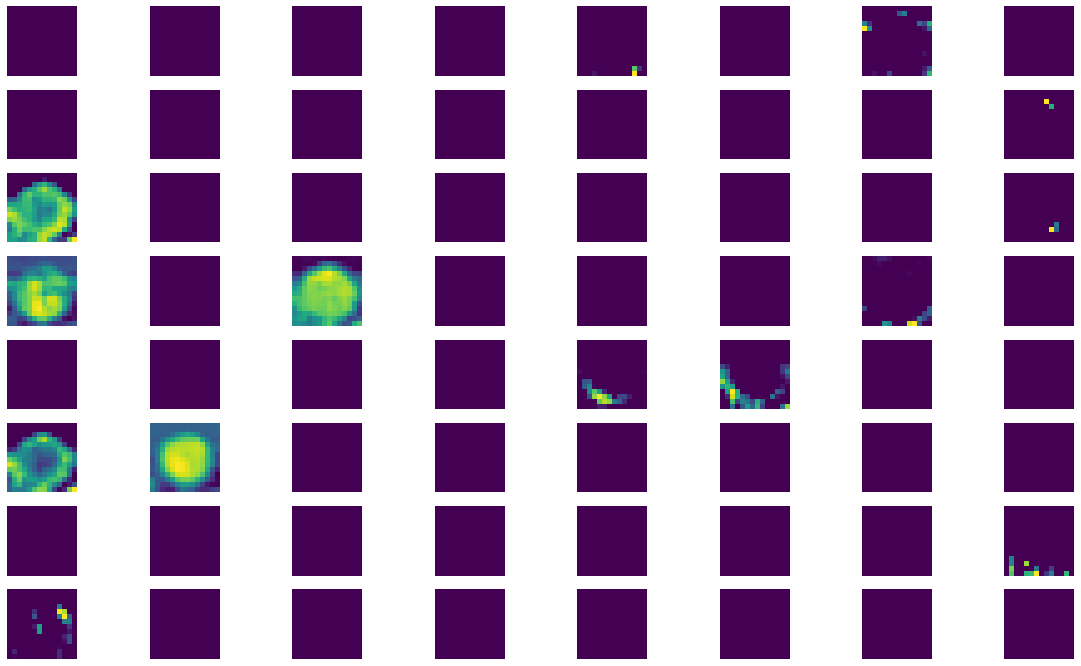

In [48]:
display_layer(outputs_history, 8, 8, 3)

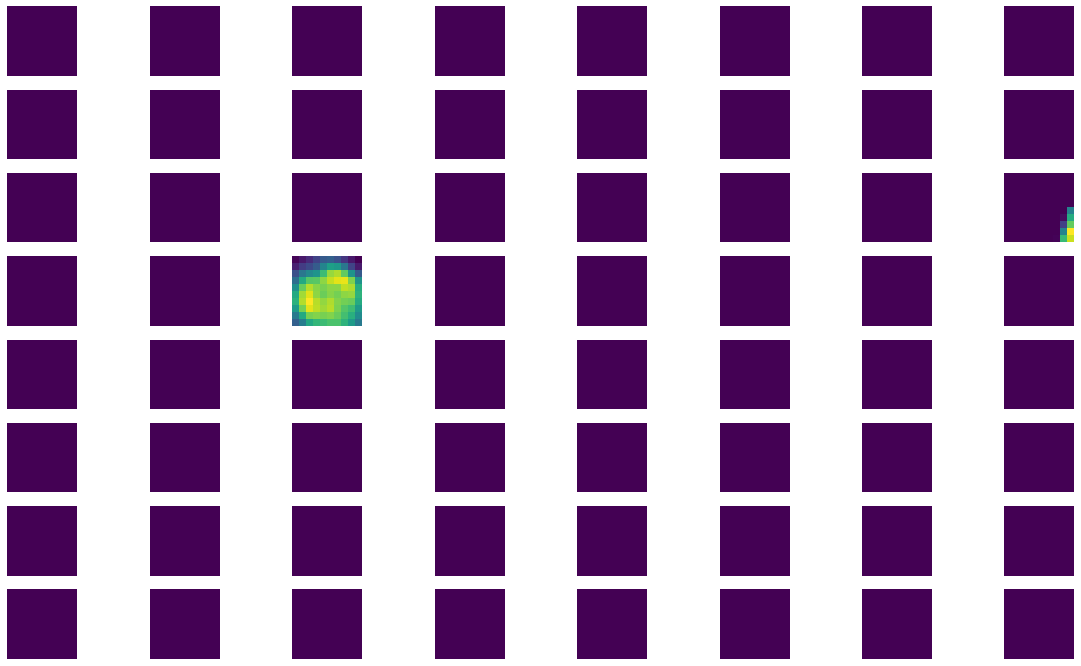

In [49]:
display_layer(outputs_history, 8, 8, 4)